## TK's simultaneous juxtracellular-imaging recording

In [1]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import os
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)
from datetime import datetime
from glob import glob
from trefide.temporal import TrendFilter
from scipy import signal

In [2]:
from keras.models import load_model
from spikeDetectionNN.spikeDetector import prepare_sequences, create_lstm_model
from spikeDetectionNN.utils import detected_peak_spikes, plot_spks, plot_test_performance, print_spike_detection_report

Using TensorFlow backend.


## Training with all simultaneous recording data (4 cells)

In [3]:
files = ['tmpData/TK09282017Fish1-1_ex_spk_voltr.npz', 
         'tmpData/TK09212017Fish1-1_ex_spk_voltr.npz', 
         'tmpData/TK10052017Fish2-2_ex_spk_voltr.npz',
         'tmpData/YS_in_spk_voltr.npz']

spkcount_set = np.array([])
voltr_set = np.array([])
devoltr_set = np.array([])

for nfile in files:
    dat = np.load(nfile)
    spkcount, voltr, devoltr = dat['arr_0'].astype('uint8'), dat['arr_1'], dat['arr_2']
#     print(len(spkcount))
    spkcount_set = np.concatenate((spkcount_set, spkcount))
    voltr_set = np.concatenate((voltr_set, voltr))
    devoltr_set = np.concatenate((devoltr_set, devoltr))

In [4]:
window_length = 40
x1_, contain_outliers_ = prepare_sequences(voltr_set, spkcount_set, window_length)
x2_, _ = prepare_sequences(devoltr_set, spkcount_set, window_length)
x_ = x1_
train_test_index = np.random.rand(x_.shape[0])>0.3
x_test = x_[~train_test_index, :, :]
y_test = contain_outliers_[~train_test_index][:, np.newaxis]
x_train = x_[train_test_index, :, :]
y_train = contain_outliers_[train_test_index][:, np.newaxis]

### Training from previously trained model

In [5]:
trained_model = sorted(glob('tmpData/partly_trained_spikeDetector_20*.h5'))[-1]

if trained_model is None:
    hidden_dim = 100
    window_length = 40
    m = create_lstm_model(hidden_dim, window_length, m=x_.shape[2])
else:
    m = load_model(trained_model)

# m.fit(x_train, y_train, batch_size=64, nb_epoch=5, validation_data=(x_test, y_test))
# m.save('tmpData/partly_trained_spikeDetector_%s.h5'%(datetime.now().strftime("%Y_%m_%d_%H_%M_%S")))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Compute performance on testing data

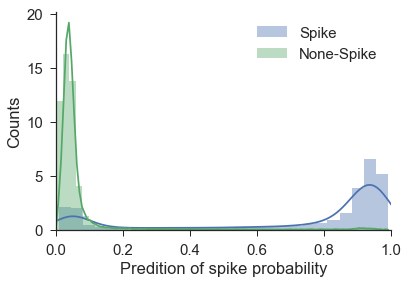

In [6]:
plot_test_performance(m, x_test, contain_outliers_[~train_test_index])

### Test detected spikes

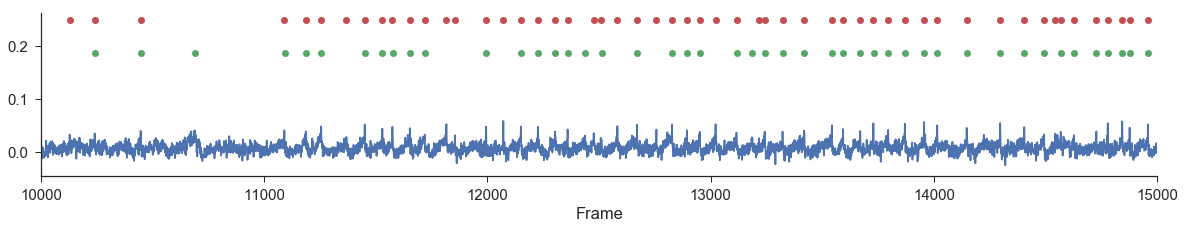

In [7]:
spk_ = detected_peak_spikes(m, x_, voltr_set, thres=0.4, devoltr_ = devoltr_set)
spk = spkcount_set>0

plt.figure(figsize=(20, 3))
plt.plot(voltr_set,'-')
plot_spks(plt, spk, voltr_set.max()*1.5, label='Raw spike time')
plot_spks(plt, spk_, voltr_set.max()*2.0, label='Detected spike time')
plt.xlabel('Frame')
plt.xlim([10000, 15000])
# plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
sns.despine()
plt.show()

In [8]:
cell_frames = [0, 36299, 36297, 36298, 24001]
cell_frames = np.cumsum(cell_frames)

for ncell in range(4):
    range_ = range(cell_frames[ncell],cell_frames[ncell+1])
    spk_in_range = spk[range_]
    spkc_in_range = spk_[range_]
    print_spike_detection_report(spk_in_range, spkc_in_range, 'Result of Cell #%d'%(ncell+1))

-------------------
Result of Cell #1
Total ephys spikes 338
Total detected spikes 404
Found spikes 307
Unfound spikes 31
Extra spikes 97
-------------------
Result of Cell #2
Total ephys spikes 306
Total detected spikes 146
Found spikes 138
Unfound spikes 168
Extra spikes 8
-------------------
Result of Cell #3
Total ephys spikes 76
Total detected spikes 101
Found spikes 72
Unfound spikes 4
Extra spikes 29
-------------------
Result of Cell #4
Total ephys spikes 46
Total detected spikes 46
Found spikes 46
Unfound spikes 0
Extra spikes 0


### Test on completely untrained data -- Amrita's annonated data

In [9]:
import pickle as pkl
folder = '/groups/svoboda/svobodalab/users/Amrita/STVoltron/402361/Annotated/'
cellId = 'Cell_12'

with open(folder + cellId + '_spikes.pkl', 'rb') as f:
    spk = pkl.load(f)
    voltr_as = -spk['dF_F']
    voltr = spk['dF'] + spk['F0']
    voltr_ = 1 - voltr / signal.savgol_filter(voltr, 511, 3)
    spkTime = spk['spike_frames_manual'].astype(int)
    spkcount = np.empty(voltr.shape)
    spkcount[:] = False
    spkcount[spkTime] = True

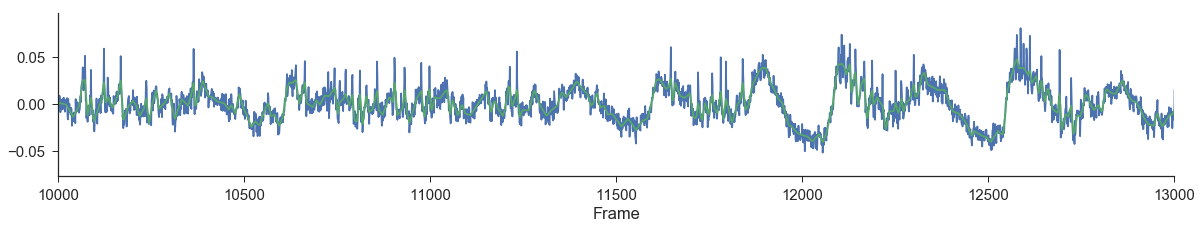

In [10]:
filt = TrendFilter(len(voltr_))
denoised_voltr = filt.denoise(voltr_)

plt.figure(figsize=(20, 3))
plt.plot(voltr_,'-')
plt.plot(denoised_voltr,'-')
plt.xlabel('Frame')
plt.xlim([10000, 13000])
sns.despine()
plt.show()

In [11]:
window_length = 40
x_, contain_outliers_ = prepare_sequences(voltr_, spkcount, window_length)

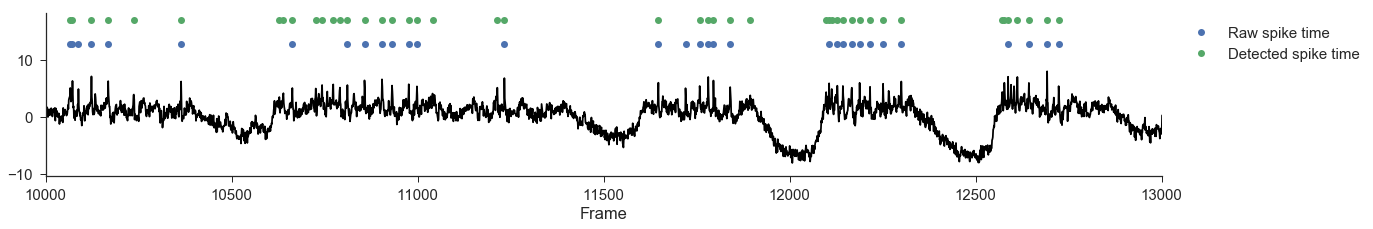

In [12]:
spk_ = detected_peak_spikes(m, x_, voltr_, thres=0.4, devoltr_ = denoised_voltr, peakThres=.9, peak_minDist=10, smallPeakThres = 20)
spk = spkcount

plt.figure(figsize=(20, 3))
plot_spks(plt, spk, voltr_as.max()*1.5, label='Raw spike time')
plot_spks(plt, spk_, voltr_as.max()*2.0, label='Detected spike time')
plt.plot(voltr_as,'-k')
plt.xlabel('Frame')
plt.xlim([10000, 13000])
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
sns.despine()
plt.show()

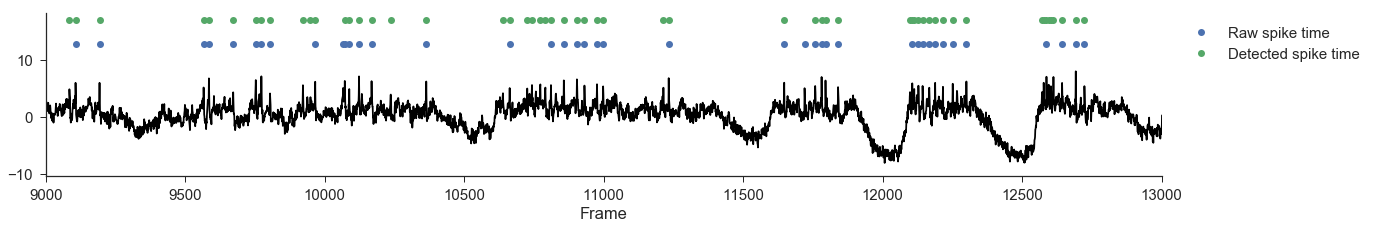

In [13]:
spk_ = detected_peak_spikes(m, x_, voltr_, thres=0.4, devoltr_ = denoised_voltr, peakThres=.8, peak_minDist=8, smallPeakThres = 40)
spk = spkcount

plt.figure(figsize=(20, 3))
plot_spks(plt, spk, voltr_as.max()*1.5, label='Raw spike time')
plot_spks(plt, spk_, voltr_as.max()*2.0, label='Detected spike time')
plt.plot(voltr_as,'-k')
plt.xlabel('Frame')
plt.xlim([9000, 13000])
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
sns.despine()
plt.show()